# Setup

In [3]:
import pathlib
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from PIL import Image

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
data_path = pathlib.Path("/opt/data/covid19")

# Train valid split

In [5]:
import sklearn.model_selection
import shutil

In [6]:
dataset_path = data_path / "train_raw"
labels_path = dataset_path / "labels.tsv"
labels = pd.read_csv(labels_path, sep="\t")
labels.shape, labels.group.unique().shape

((432, 5), (24,))

In [8]:
groups = labels[["label", "group"]].drop_duplicates().sort_values(by=["label", "group"])

In [9]:
sklearn.model_selection.train_test_split(groups)
train_groups, valid_groups = sklearn.model_selection.train_test_split(
    groups, test_size=1/6, random_state=13, stratify=groups.label
)
train_groups.shape, valid_groups.shape

((20, 2), (4, 2))

In [10]:
def copy_ds(ds, src, dst):
    (dst / "images").mkdir(parents=True, exist_ok=True)
    ds.to_csv(dst / "labels.tsv", index=False, sep="\t")
    for path in ds.path:
        shutil.copy(src / path, dst / path)

In [11]:
(labels[labels.group.isin(train_groups.group.values)].shape,
 labels[labels.group.isin(valid_groups.group.values)].shape)

((360, 5), (72, 5))

In [12]:
copy_ds(labels[labels.group.isin(train_groups.group.values)], dataset_path, data_path / "train")
copy_ds(labels[labels.group.isin(valid_groups.group.values)], dataset_path, data_path / "valid")

# Train DL model

In [13]:
import time
import os
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

In [24]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [25]:
class CovidDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform):
        self.data_path = data_path
        self.transform = transform
        self.labels = pd.read_csv(self.data_path / "labels.tsv", sep="\t").fillna(-1)
        self.classes = ["healthy", "infected"]
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        image_path = self.data_path / row.path
        image = Image.open(image_path.open("rb"))
        image = self.transform(image)
        return image, row.label_i

In [26]:
ds_types = ['train', 'valid']
image_datasets = {
    x: CovidDataset(data_path / x, data_transforms[x]) for x in ds_types
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=x == "train", num_workers=4)
    for x in ds_types
}
dataset_sizes = {x: len(image_datasets[x]) for x in ds_types}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

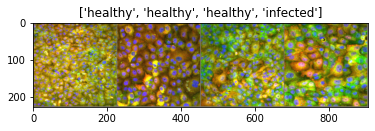

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, phases=('train', 'valid')):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == phases[-1] and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

In [29]:
model_ft = models.resnet18(pretrained=True)
# model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [30]:
train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10, phases=ds_types
);

Epoch 0/9
----------
train Loss: 0.7308 Acc: 0.7083
valid Loss: 0.2600 Acc: 0.8750

Epoch 1/9
----------
train Loss: 0.5158 Acc: 0.8139
valid Loss: 0.3908 Acc: 0.8056

Epoch 2/9
----------
train Loss: 0.5740 Acc: 0.8056
valid Loss: 0.3553 Acc: 0.8333

Epoch 3/9
----------
train Loss: 0.3897 Acc: 0.8500
valid Loss: 0.0968 Acc: 0.9444

Epoch 4/9
----------
train Loss: 0.6283 Acc: 0.7667
valid Loss: 0.8261 Acc: 0.6667

Epoch 5/9
----------
train Loss: 0.5828 Acc: 0.8028
valid Loss: 0.0663 Acc: 0.9583

Epoch 6/9
----------
train Loss: 0.4244 Acc: 0.8361
valid Loss: 0.5188 Acc: 0.7361

Epoch 7/9
----------
train Loss: 0.2900 Acc: 0.8806
valid Loss: 0.2751 Acc: 0.8889

Epoch 8/9
----------
train Loss: 0.2646 Acc: 0.8722
valid Loss: 0.2999 Acc: 0.8472

Epoch 9/9
----------
train Loss: 0.2895 Acc: 0.9056
valid Loss: 0.2594 Acc: 0.9306

Training complete in 4m 9s
Best val Acc: 0.958333


# Predict and prepare submission and model

In [37]:
from collections import defaultdict

In [46]:
def predict(model, dataloader):
    results = defaultdict(list)
    with torch.set_grad_enabled(False):
        model.eval()
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            results["labels"].extend(labels.tolist())
            results["probs"].extend(probs.tolist())
            results["preds"].extend(preds.tolist())
    
    if results["labels"][0] >= 0:
        labels = np.array([class_names[i] for i in results["labels"]])
    else:
        labels = []
    probs = np.array(results["probs"])[:,1]
    preds = np.array([class_names[i] for i in results["preds"]])
    return labels, probs, preds

In [40]:
labels, probs, preds = predict(model_ft, dataloaders["valid"])
preds_df = pd.DataFrame({
    "id": dataloader.dataset.labels.id,
    "label": labels,
    "group": dataloader.dataset.labels.group,
    "prob": probs,
    "pred": preds,
})
preds_df.head()

,id,label,group,prob,pred
0,11c8e7e766868356,healthy,11522fb53da0f6ef,0.000641,healthy
1,6aaac3b6b9c2a620,healthy,11522fb53da0f6ef,0.026469,healthy
2,9229dfaf21443f5d,healthy,11522fb53da0f6ef,0.002288,healthy
3,9b4404e5e4d38535,healthy,11522fb53da0f6ef,0.003044,healthy
4,f19f9ec0438a79d0,healthy,11522fb53da0f6ef,0.005792,healthy


In [42]:
dataloader = torch.utils.data.DataLoader(image_datasets["train"], batch_size=4, shuffle=False, num_workers=4)
labels, probs, preds = predict(model_ft, dataloader)
train_preds_df = pd.DataFrame({
    "id": dataset.labels.id,
    "label": labels,
    "group": dataset.labels.group,
    "prob": probs,
    "pred": preds,
})
preds_df.head()

,id,label,group,prob,pred
0,11c8e7e766868356,healthy,11522fb53da0f6ef,0.000641,healthy
1,6aaac3b6b9c2a620,healthy,11522fb53da0f6ef,0.026469,healthy
2,9229dfaf21443f5d,healthy,11522fb53da0f6ef,0.002288,healthy
3,9b4404e5e4d38535,healthy,11522fb53da0f6ef,0.003044,healthy
4,f19f9ec0438a79d0,healthy,11522fb53da0f6ef,0.005792,healthy


In [47]:
test_dataset = CovidDataset(data_path / "test", data_transforms["valid"])
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)
labels, probs, preds = predict(model_ft, test_dataloader)
pred_label_i = (probs > 0.5).astype(int)
pred_label_i.shape

(216,)

In [49]:
sumisssion_df = test_dataset.labels.copy()
sumisssion_df["label_i"] = pred_label_i
sumisssion_df

,id,path,label_i
0,2de8b6da3708d931,images/2de8b6da3708d931.png,1
1,b23d64bb221c0d1f,images/b23d64bb221c0d1f.png,1
2,200ac2b3105d8eb7,images/200ac2b3105d8eb7.png,1
3,8f41b2d16e8b553e,images/8f41b2d16e8b553e.png,1
4,91912bd0824a32e4,images/91912bd0824a32e4.png,1
...,...,...,...
211,f6a269ea8130c0e9,images/f6a269ea8130c0e9.png,0
212,df222f812088787b,images/df222f812088787b.png,0
213,d000d798642e825c,images/d000d798642e825c.png,0
214,fd6c3ce27aeed21a,images/fd6c3ce27aeed21a.png,0


In [50]:
sumisssion_df.to_csv(data_path / "submission.tsv", sep="\t", index=False)

In [55]:
torch.save(model_ft.state_dict(), pathlib.Path("example_model/model.pt").open("wb"))